In [7]:
import xarray as xr
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os

In [10]:
# to modify based on the data directory
root_directory = 'C:/Users/bmillet/Documents/LSCE/Thèse LSCE/GitHub/d18o-southern-ocean/'
data_path = r'D:/Data/d18o_so/'
fig_path = '/figures/optimization/'

In [12]:
import sys
sys.path.append(root_directory + '/scripts/') # go to parent dir
import usefull_functions as uf

%load_ext autoreload
%autoreload 2

In [27]:
if not os.path.exists(root_directory + fig_path): os.mkdir(root_directory + fig_path)

In [19]:
import custom_density_scale

# Open the different files that we need

In [24]:
d18o_SO = pd.read_table(data_path + 'giss_d18o_SO.txt')

In [80]:
TMI_2deg = xr.open_dataset(data_path + 'TMI_2deg_2010_water_mass_fractions.nc')
l_lat_TMI, l_lon_TMI = TMI_2deg['yt'].values.copy(), TMI_2deg['xt'].values.copy(); l_depth_TMI = TMI_2deg['zt'].values

In [235]:
ocim_frac2 = xr.open_dataset(data_path + 'ocim_steady_dyes.nc')
l_lat_ocim, l_lon_ocim, l_depth_ocim = ocim_frac2['yt'].values, ocim_frac2['xt'].values, ocim_frac2['zt'].values

In [86]:
dyes_ocim = np.empty((6, 48, 91, 180)); dyes_TMI = np.empty((6, 33, 90, 180))
for i in range(6):
    dyes_ocim[i] = ocim_frac2[uf.dyes_TMI[i] + '_steady'].values
    dyes_TMI[i] = TMI_2deg[uf.dyes_TMI[i]].values

In [110]:
nemo_dyes_regridded = xr.open_dataset(data_path + 'tm21ah21_extrapolated_dyes_regridded.nc')
l_depth = nemo_dyes_regridded['depth'].values

In [65]:
dsClim = xr.open_dataset(data_path + "climatology_Brunov2.nc")
l_lat_cas, l_lon_cas, mask_cas = dsClim['lat'].values, dsClim['lon'].values, dsClim['basin_masks'].values

In [61]:
import cartopy.crs as ccrs
from scipy.interpolate import RegularGridInterpolator

interpolator_gamma = RegularGridInterpolator((l_depth0, l_lat_cas, l_lon_cas), dsClim['gamma'].values, bounds_error = False, fill_value = None)
interpolator_salinity = RegularGridInterpolator((l_depth0, l_lat_cas, l_lon_cas), dsClim['absolute_salinity'].values, bounds_error = False, fill_value = None)

In [88]:
interpolator_frac_TMI = [RegularGridInterpolator((l_depth_TMI, l_lat_TMI, l_lon_TMI), dyes_TMI[i], bounds_error = False, fill_value = None) for i in range(6)]
interpolator_frac_nemo = [RegularGridInterpolator((l_depth, l_lat_cas, l_lon_cas), nemo_dyes_regridded[uf.dyes[i]].values, bounds_error = False, fill_value = None) for i in range(6)]
interpolator_frac_ocim = [RegularGridInterpolator((l_depth_ocim, l_lat_ocim, l_lon_ocim), dyes_ocim[i], bounds_error = False, fill_value = None) for i in range(6)]

In [112]:
d18o_SO = pd.read_table(data_path + 'giss_d18o_SO.txt')

In [114]:
d18o_SO['Longitude'] = [lon if lon >= 0 else 360 + lon for lon in d18o_SO['Longitude']]
d18o_SO.where((d18o_SO['Depth'] != -999.0) & (d18o_SO['d18O'] != '**'), np.nan, inplace = True)
d18o_SO['d18O'] = d18o_SO['d18O'].astype(float)
d18o_SO['Gamma'] = interpolator_gamma((d18o_SO['Depth'], d18o_SO['Latitude'], d18o_SO['Longitude']))
d18o_SO['absolute_salinity'] = interpolator_salinity((d18o_SO['Depth'], d18o_SO['Latitude'], d18o_SO['Longitude']))

In [116]:
aux = d18o_SO.where((d18o_SO['Gamma'] <= 28.6) & (d18o_SO['Gamma'] >= 27)).dropna()
dfs = uf.create_dfs(aux)

# Plot the SO GISS compilation

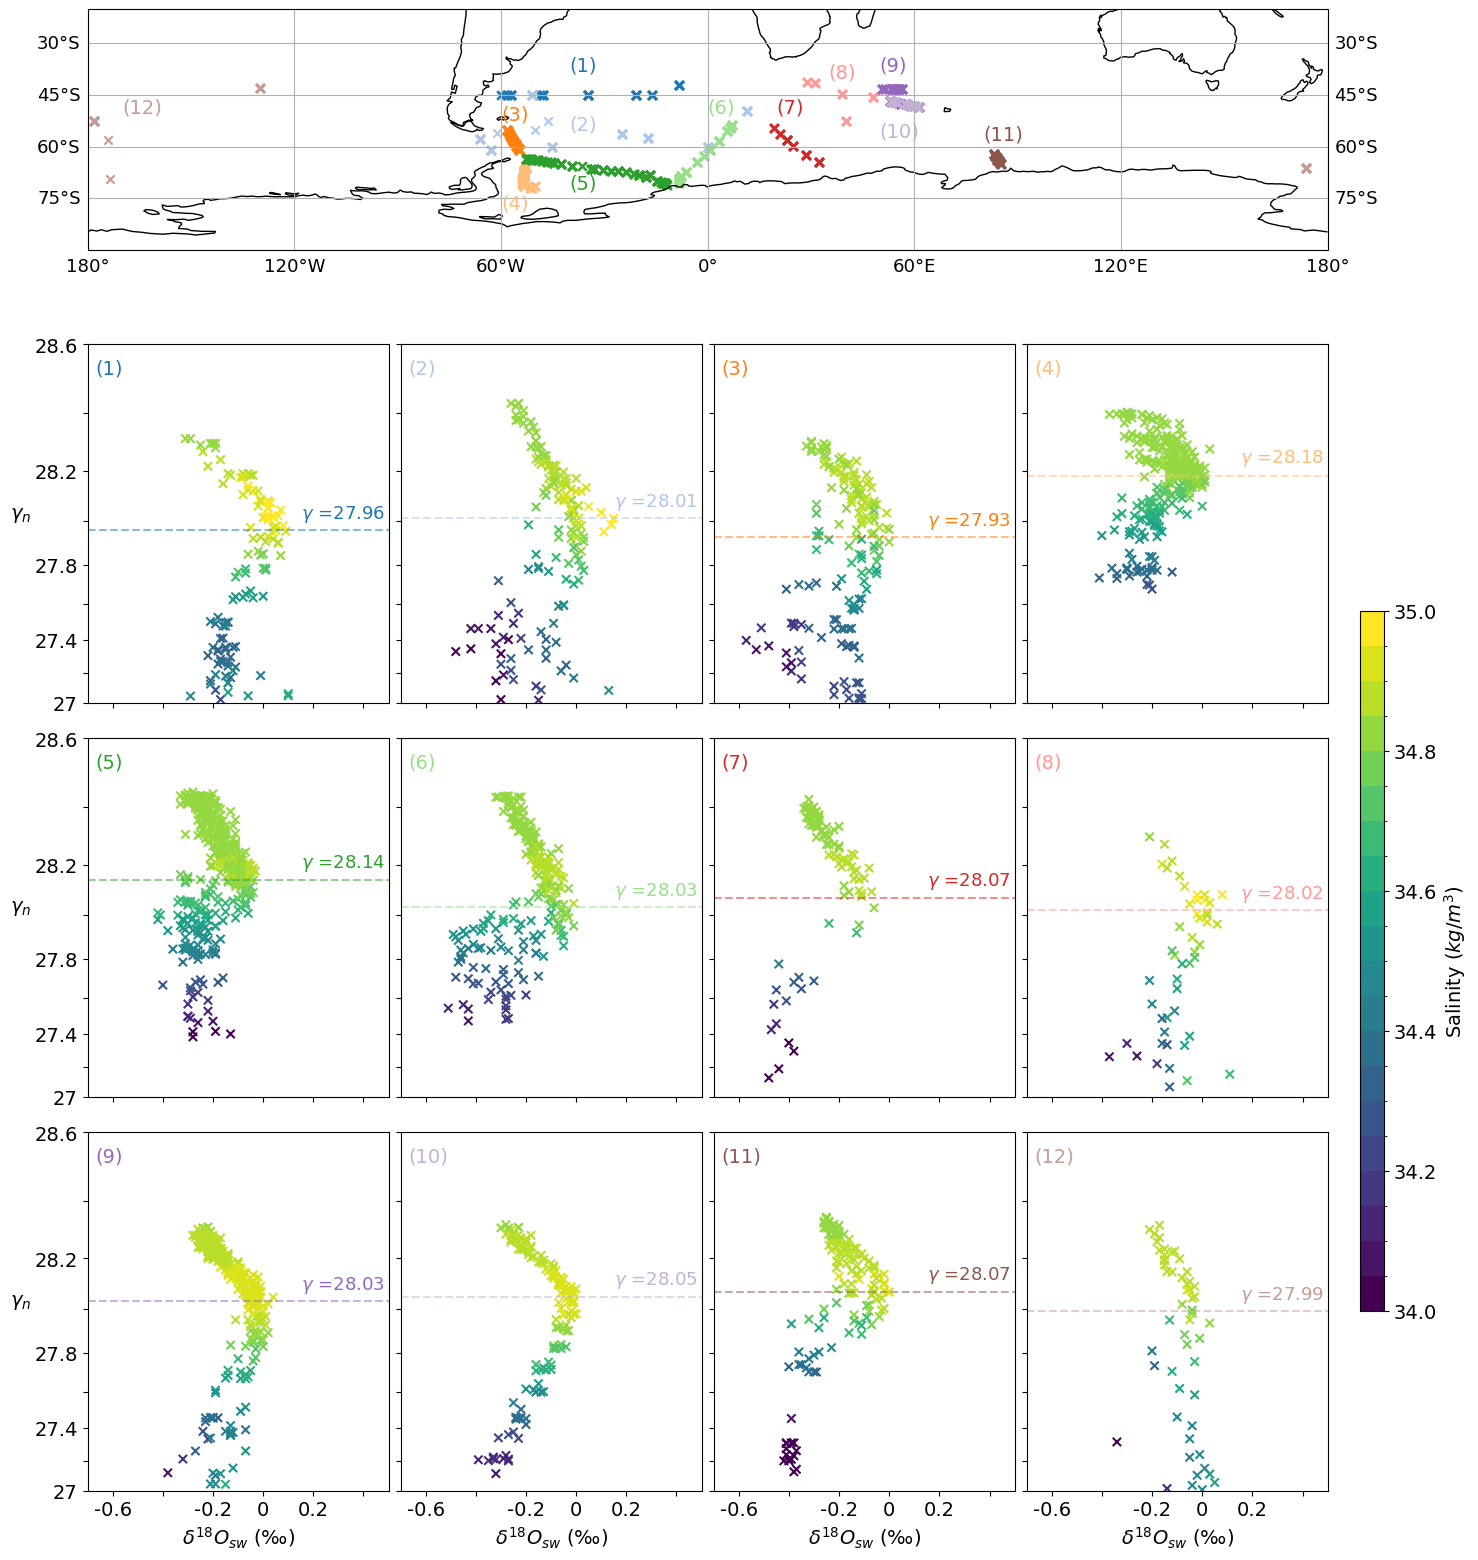

In [ ]:
fig = plt.figure(figsize = (16, 20)); gs = fig.add_gridspec(4, 4, wspace = 0.04, hspace = 0.1); font = 14

ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m'); gl = ax.gridlines(draw_labels = {'bottom': 'x', 'right': 'y', 'left': 'y'}, ylocs = [-90 + 15 * i for i in range(5)])
gl.xlabel_style = {'size': font - 1}; gl.ylabel_style = {'size': font - 1}; ax.set_ylim(-90, -20); ax.set_xlim(-180, 180); couleurs = plt.cm.tab20(range(12))
for i in range(12):
    ax.scatter(dfs[i]['Longitude'], dfs[i]['Latitude'], color = couleurs[i], marker = 'x')
    ax.text(uf.coords_dataset[i][0], uf.coords_dataset[i][1], '(' + str(i+1) + ')', fontsize = font, color = couleurs[i])


norm_S = uf.get_BoundNorm(34, 35, nbins = 20)
for i in range(12):
    i_row, i_col = i//4 + 1, i%4; xlabels, ylabels = uf.get_xylabels(3, 4, i)

    ax = fig.add_subplot(gs[i_row, i_col])
    sc = ax.scatter(dfs[i]['d18O'], dfs[i]['Gamma'], marker = 'x', c = dfs[i]['absolute_salinity'], norm = norm_S)
    
    ax.axhline(y = uf.l_neut_dens[i], ls = '--', color = couleurs[i], alpha = 0.5); ax.text(0.15, uf.l_neut_dens[i] + 0.05, '$\gamma$ =' + str(uf.l_neut_dens[i]), fontsize = font - 1, color = couleurs[i])
    ax.text(-0.67, 28.52, '(' + str(i + 1) + ')', fontsize = font, color = couleurs[i])
    
    ax.set_yscale('custom_scale'); ax.invert_yaxis()
    uf.plot_details_axis(ax, sc, cb = False, xlim = (-0.7, 0.5), ylim = (28.6, 27), nbins = 20, xticks = [-0.6 + 0.2*i for i in range(6)], yticks = [27 + 0.2*i for i in range(9)], font = font, xlabels = xlabels, ylabels = ylabels)
    
    if ylabels: ax.set_ylabel('$\gamma_n$', fontsize = font, rotation = 0, labelpad = 10); ax.set_yticklabels(['27', '', '27.4', '', '27.8', '', '28.2', '', '28.6'], fontsize = font)
    if xlabels: ax.set_xlabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font); ax.set_xticklabels([-0.6, '', -0.2, 0, 0.2, ''], fontsize = font)
    
uf.add_cbar(fig, sc, y = 0.2, height = 0.35, fontsize = font, label = 'Salinity ($kg/m^3$)', ticks = [34 + i * 0.2 for i in range (6)])

plt.savefig(root_directory + fig_path + 'd18o_profiles_SO_map.png', bbox_inches = 'tight')

## Plot the GISS d18o SO comp selected for the optimization

In [121]:
aux2 = aux.where(aux['Depth']>= 150).dropna()
dfs2 = uf.create_dfs(aux2)

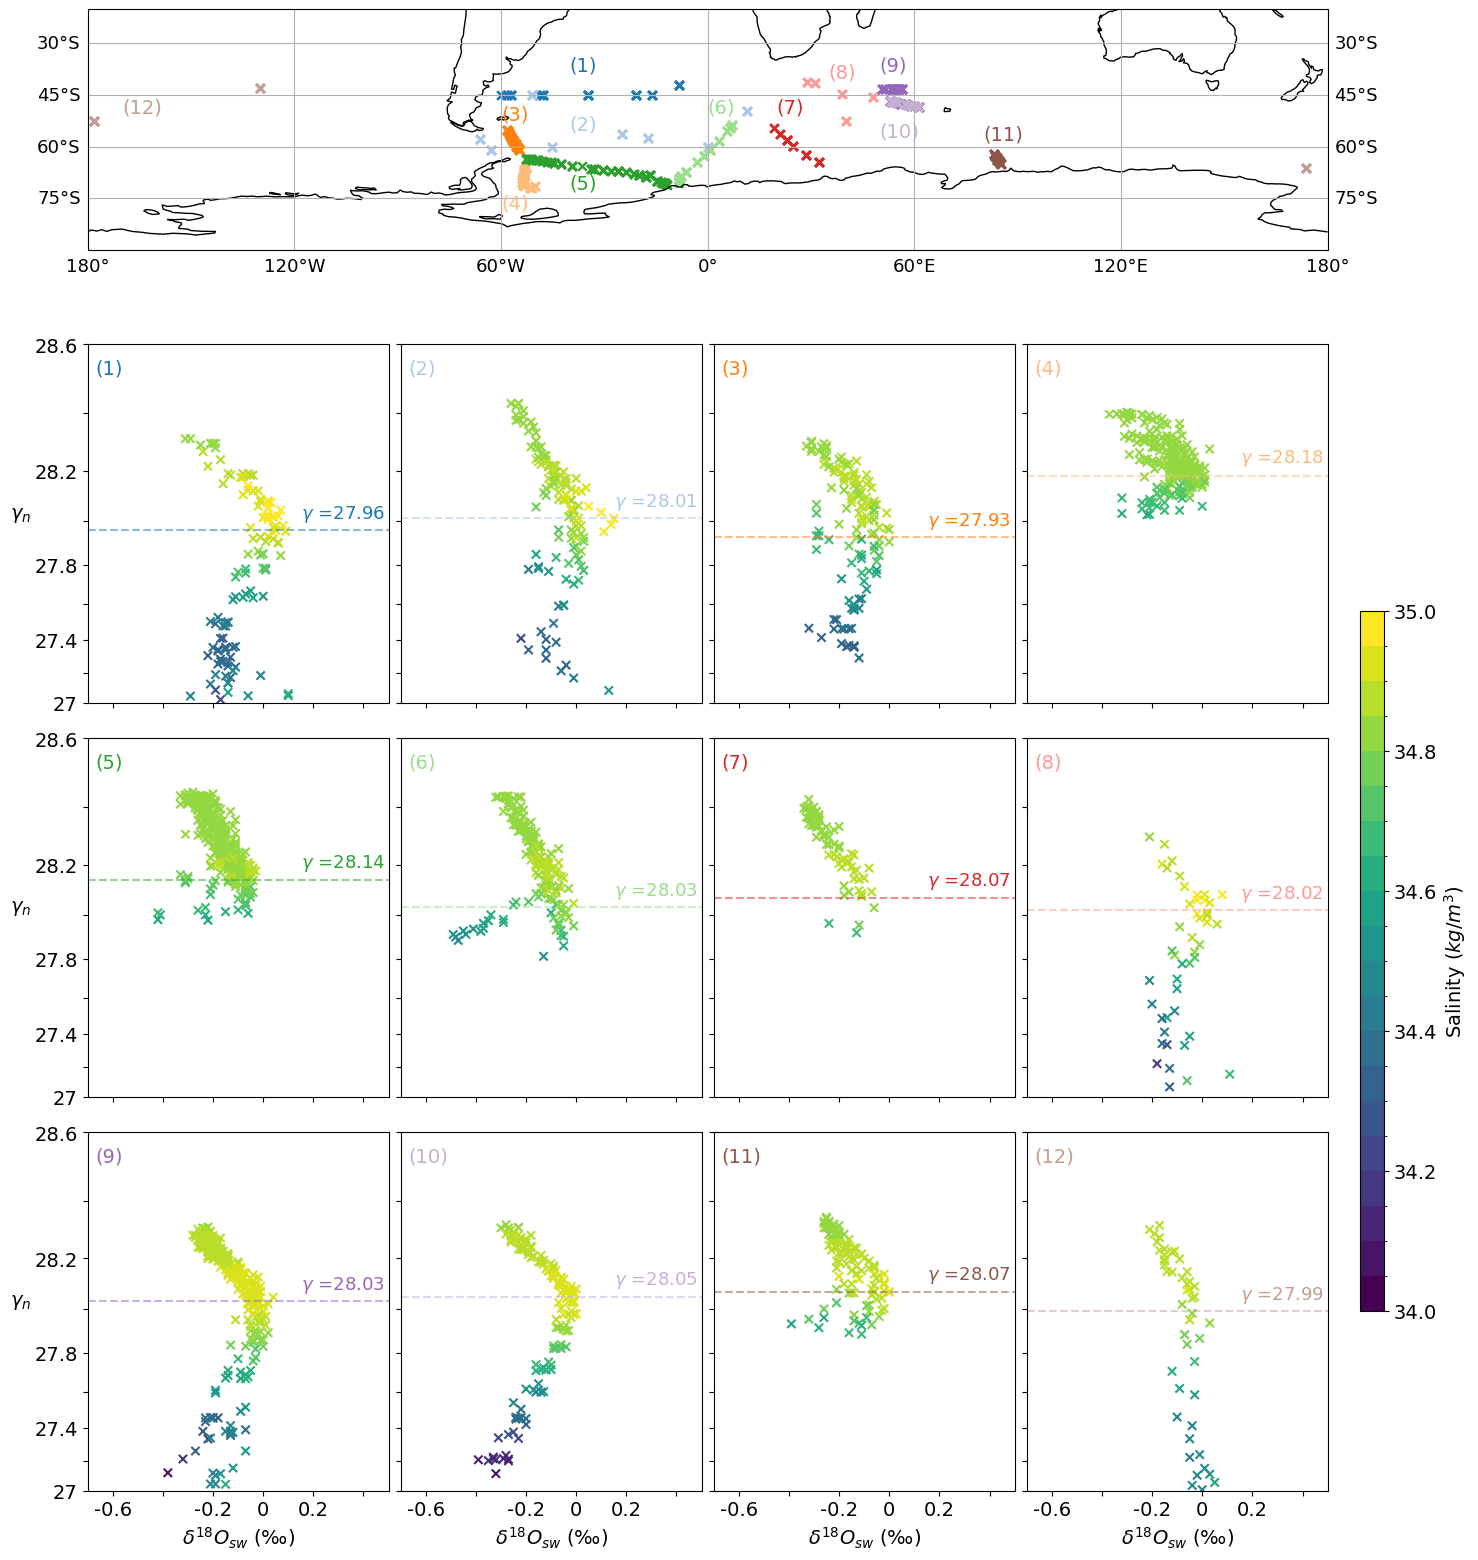

In [125]:
fig = plt.figure(figsize = (16, 20)); gs = fig.add_gridspec(4, 4, wspace = 0.04, hspace = 0.1); font = 14

ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m'); gl = ax.gridlines(draw_labels = {'bottom': 'x', 'right': 'y', 'left': 'y'}, ylocs = [-90 + 15 * i for i in range(5)])
gl.xlabel_style = {'size': font - 1}; gl.ylabel_style = {'size': font - 1}; ax.set_ylim(-90, -20); ax.set_xlim(-180, 180); couleurs = plt.cm.tab20(range(12))
for i in range(12):
    ax.scatter(dfs2[i]['Longitude'], dfs2[i]['Latitude'], color = couleurs[i], marker = 'x')
    ax.text(uf.coords_dataset[i][0], uf.coords_dataset[i][1], '(' + str(i+1) + ')', fontsize = font, color = couleurs[i])


norm_S = uf.get_BoundNorm(34, 35, nbins = 20)
for i in range(12):
    i_row, i_col = i//4 + 1, i%4; xlabels, ylabels = uf.get_xylabels(3, 4, i)

    ax = fig.add_subplot(gs[i_row, i_col])
    sc = ax.scatter(dfs2[i]['d18O'], dfs2[i]['Gamma'], marker = 'x', c = dfs2[i]['absolute_salinity'], norm = norm_S)
    
    ax.axhline(y = uf.l_neut_dens[i], ls = '--', color = couleurs[i], alpha = 0.5); ax.text(0.15, uf.l_neut_dens[i] + 0.05, '$\gamma$ =' + str(uf.l_neut_dens[i]), fontsize = font - 1, color = couleurs[i])
    ax.text(-0.67, 28.52, '(' + str(i + 1) + ')', fontsize = font, color = couleurs[i])
    
    ax.set_yscale('custom_scale'); ax.invert_yaxis()
    uf.plot_details_axis(ax, sc, cb = False, xlim = (-0.7, 0.5), ylim = (28.6, 27), nbins = 20, xticks = [-0.6 + 0.2*i for i in range(6)], yticks = [27 + 0.2*i for i in range(9)], font = font, xlabels = xlabels, ylabels = ylabels)
    
    if ylabels: ax.set_ylabel('$\gamma_n$', fontsize = font, rotation = 0, labelpad = 10); ax.set_yticklabels(['27', '', '27.4', '', '27.8', '', '28.2', '', '28.6'], fontsize = font)
    if xlabels: ax.set_xlabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font); ax.set_xticklabels([-0.6, '', -0.2, 0, 0.2, ''], fontsize = font)
    
uf.add_cbar(fig, sc, y = 0.2, height = 0.35, fontsize = font, label = 'Salinity ($kg/m^3$)', ticks = [34 + i * 0.2 for i in range (6)])

plt.savefig(root_directory + fig_path + 'd18o_profiles_SO_map_optimization.png', bbox_inches = 'tight')

## Optimization

In [147]:
from scipy.optimize import minimize

In [136]:
aux2 = aux.where(aux['Depth']>= 150).dropna()

for i in range(6):
    aux2[uf.dyes_TMI[i] + '_ocim'] = interpolator_frac_ocim[i]((aux2['Depth'], aux2['Latitude'], aux2['Longitude']))
    aux2[uf.dyes_TMI[i] + '_TMI'] = interpolator_frac_TMI[i]((aux2['Depth'], aux2['Latitude'], aux2['Longitude']))
    aux2[uf.dyes_TMI[i] + '_nemo'] = interpolator_frac_nemo[i]((aux2['Depth'], aux2['Latitude'], aux2['Longitude']))
    
dfs2 = uf.create_dfs(aux2)

In [143]:
# we need a function to use scipy.optimize.minimize that takes only one argument --> hence the 3 different functions

def objective_TMI(d18o_sources):
    d18o_reconstruct = d18o_sources.dot(fractions_TMI)
    return np.sum((d18o_obs - d18o_reconstruct)**2)

def objective_ocim(d18o_sources):
    d18o_reconstruct = d18o_sources.dot(fractions_ocim)
    return np.sum((d18o_obs - d18o_reconstruct)**2)

def objective_ocim(d18o_sources):
    d18o_reconstruct = d18o_sources.dot(fractions_ocim)
    return np.sum((d18o_obs - d18o_reconstruct)**2)

### First optimization

### Second optimization

In [161]:
d18o_initial_values = np.array([0.5, -0.3, -0.35, -0.2, 0.3, -0.4])
l_results_TMI, l_results_ocim, l_results_nemo = [], [], []; bounds = [(-1, 1) for i in range(6)]
bounds[0] = (0.4499,0.4501); bounds[2] = (-0.3501,-0.3499)

for i in range(12):
    d18o_obs = dfs2[i]['d18O']
    fractions_TMI = np.array([dfs2[i][uf.dyes_TMI[j] + '_TMI'] for j in range(6)])
    fractions_ocim = np.array([dfs2[i][uf.dyes_TMI[j] + '_ocim'] for j in range(6)])
    fractions_nemo = np.array([dfs2[i][uf.dyes_TMI[j] + '_nemo'] for j in range(6)])

    l_results_TMI.append(minimize(objective_TMI, d18o_initial_values, bounds=bounds))
    l_results_nemo.append(minimize(objective_nemo, d18o_initial_values, bounds=bounds))
    l_results_ocim.append(minimize(objective_ocim, d18o_initial_values, bounds=bounds))

In [162]:
# function to print the max fraction of a given dataset based on the dye name: 'dye' + region + '_' + [TMI, nemo, ocim]

def print_max(dye_name, j):
    return format(np.nanmax(dfs2[j][dye_name]), '.2f')

In [167]:
d18o_EM_values_TMI = np.empty((6, 12))

for j in range(12):
    print('Dataset '+str(j+1)+': D18O LL: ' + format(l_results_TMI[j].x[0], '.2f') + ', MS: '+ format(l_results_TMI[j].x[1], '.2f') + ', NP: '+ format(l_results_TMI[j].x[2], '.2f') + ', HS: '+ format(l_results_TMI[j].x[3], '.2f')+ ', NA: '+ format(l_results_TMI[j].x[4], '.2f') + ', AA: '+ format(l_results_TMI[j].x[5], '.2f'))
    d18o_EM_values_TMI[:, j] = l_results_TMI[j].x
    # print('Max: LL ' + print_max('dyeLL_TMI', j) +', MS ' + print_max('dyeMS_TMI', j)+', HS ' + print_max('dyeHS_TMI', j))

Dataset 1: D18O LL: 0.45, MS: 0.09, NP: -0.35, HS: -0.21, NA: 0.33, AA: -0.39
Dataset 2: D18O LL: 0.45, MS: 0.29, NP: -0.35, HS: -0.11, NA: 0.35, AA: -0.30
Dataset 3: D18O LL: 0.45, MS: 1.00, NP: -0.35, HS: -0.16, NA: 0.09, AA: -0.19
Dataset 4: D18O LL: 0.45, MS: 1.00, NP: -0.35, HS: 1.00, NA: -0.28, AA: -0.12
Dataset 5: D18O LL: 0.45, MS: 1.00, NP: -0.35, HS: 1.00, NA: -0.51, AA: -0.16
Dataset 6: D18O LL: 0.45, MS: 1.00, NP: -0.35, HS: 0.00, NA: 0.19, AA: -0.31
Dataset 7: D18O LL: 0.45, MS: 1.00, NP: -0.35, HS: -0.14, NA: 0.62, AA: -0.58
Dataset 8: D18O LL: 0.45, MS: 0.38, NP: -0.35, HS: -0.23, NA: 0.25, AA: -0.33
Dataset 9: D18O LL: 0.45, MS: -0.07, NP: -0.35, HS: -0.25, NA: 0.52, AA: -0.52
Dataset 10: D18O LL: 0.45, MS: 1.00, NP: -0.35, HS: -0.33, NA: 0.50, AA: -0.52
Dataset 11: D18O LL: 0.45, MS: 1.00, NP: -0.35, HS: 0.12, NA: 0.50, AA: -0.62
Dataset 12: D18O LL: 0.45, MS: 0.85, NP: -0.35, HS: -0.03, NA: 0.29, AA: -0.34


In [169]:
d18o_EM_values_ocim = np.empty((6, 12))

for j in range(12):
    print('NEMO: D18O LL: ' + format(l_results_ocim[j].x[0], '.2f') + ', MS: '+ format(l_results_ocim[j].x[1], '.2f') + ', NP: '+ format(l_results_ocim[j].x[2], '.2f') + ', HS: '+ format(l_results_ocim[j].x[3], '.2f')+ ', NA: '+ format(l_results_ocim[j].x[4], '.2f') + ', AA: '+ format(l_results_ocim[j].x[5], '.2f'))
    d18o_EM_values_ocim[:, j] = l_results_ocim[j].x

NEMO: D18O LL: 0.45, MS: 0.24, NP: -0.35, HS: -0.20, NA: 0.30, AA: -0.45
NEMO: D18O LL: 0.45, MS: 1.00, NP: -0.35, HS: -0.22, NA: 0.33, AA: -0.40
NEMO: D18O LL: 0.45, MS: 0.96, NP: -0.35, HS: -0.27, NA: 0.08, AA: -0.31
NEMO: D18O LL: 0.45, MS: 1.00, NP: -0.35, HS: 1.00, NA: -0.22, AA: -0.21
NEMO: D18O LL: 0.45, MS: 0.26, NP: -0.35, HS: -0.03, NA: 0.10, AA: -0.29
NEMO: D18O LL: 0.45, MS: 1.00, NP: -0.35, HS: -0.14, NA: 0.27, AA: -0.44
NEMO: D18O LL: 0.45, MS: 1.00, NP: -0.35, HS: -0.48, NA: 0.45, AA: -0.56
NEMO: D18O LL: 0.45, MS: 0.41, NP: -0.35, HS: -0.23, NA: 0.27, AA: -0.45
NEMO: D18O LL: 0.45, MS: -0.11, NP: -0.35, HS: -0.23, NA: 0.28, AA: -0.47
NEMO: D18O LL: 0.45, MS: -0.66, NP: -0.35, HS: -0.25, NA: 0.36, AA: -0.52
NEMO: D18O LL: 0.45, MS: 1.00, NP: -0.35, HS: -0.41, NA: 0.55, AA: -0.65
NEMO: D18O LL: 0.45, MS: -0.92, NP: -0.35, HS: 0.08, NA: 0.28, AA: -0.46


In [171]:
d18o_EM_values_nemo = np.empty((6, 12))

for j in range(12):
    print('NEMO: D18O LL: ' + format(l_results_nemo[j].x[0], '.2f') + ', MS: '+ format(l_results_nemo[j].x[1], '.2f') + ', NP: '+ format(l_results_nemo[j].x[2], '.2f') + ', HS: '+ format(l_results_nemo[j].x[3], '.2f')+ ', NA: '+ format(l_results_nemo[j].x[4], '.2f') + ', AA: '+ format(l_results_nemo[j].x[5], '.2f'))
    d18o_EM_values_nemo[:, j] = l_results_nemo[j].x

NEMO: D18O LL: 0.45, MS: 0.14, NP: -0.35, HS: -0.19, NA: 0.13, AA: -0.21
NEMO: D18O LL: 0.45, MS: 1.00, NP: -0.35, HS: -0.20, NA: 0.15, AA: -0.20
NEMO: D18O LL: 0.45, MS: 0.05, NP: -0.35, HS: -0.19, NA: 0.07, AA: -0.30
NEMO: D18O LL: 0.45, MS: -0.26, NP: -0.35, HS: -0.27, NA: 1.00, AA: -0.19
NEMO: D18O LL: 0.45, MS: -0.21, NP: -0.35, HS: 1.00, NA: 0.11, AA: -0.21
NEMO: D18O LL: 0.45, MS: 1.00, NP: -0.35, HS: -0.16, NA: 0.05, AA: -0.23
NEMO: D18O LL: 0.45, MS: 1.00, NP: -0.35, HS: -0.41, NA: 0.04, AA: -0.32
NEMO: D18O LL: 0.45, MS: 0.53, NP: -0.35, HS: -0.20, NA: 0.07, AA: -0.20
NEMO: D18O LL: 0.45, MS: -0.10, NP: -0.35, HS: -0.22, NA: 0.11, AA: -0.28
NEMO: D18O LL: 0.45, MS: 1.00, NP: -0.35, HS: -0.31, NA: 0.10, AA: -0.28
NEMO: D18O LL: 0.45, MS: -1.00, NP: -0.35, HS: -0.67, NA: 0.21, AA: -0.28
NEMO: D18O LL: 0.45, MS: 0.17, NP: -0.35, HS: -0.03, NA: 0.02, AA: -0.17


### Plot of the deep dyes per dataset

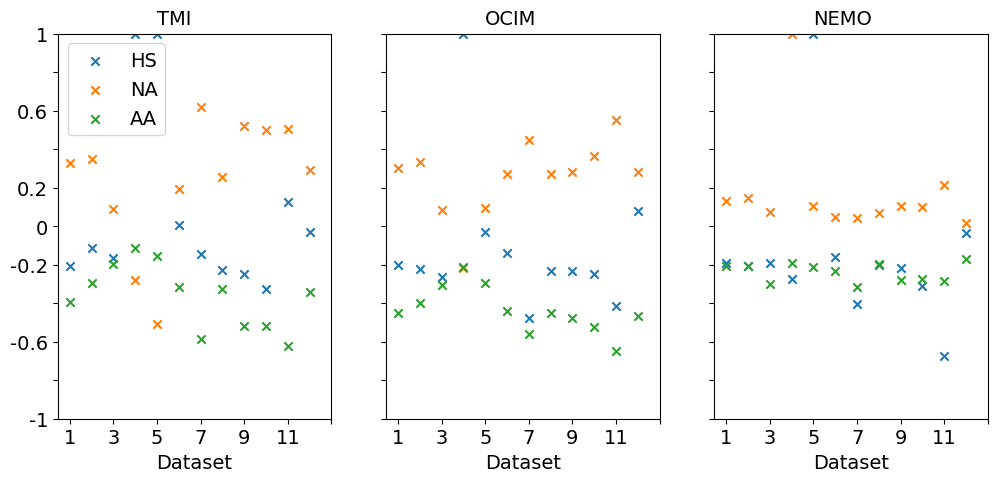

In [188]:
fig = plt.figure(figsize = (12, 5)); gs = fig.add_gridspec(1, 3, hspace = 0.1); fontsize = 14
EM_values = [d18o_EM_values_TMI, d18o_EM_values_ocim, d18o_EM_values_nemo]
models = ['TMI', 'OCIM', 'NEMO']

for j in range(3):
    ax = fig.add_subplot(gs[0, j])
    for i in [3, 4, 5]:
        ax.scatter(range(12), EM_values[j][i, :], label = uf.dyes[i].replace('Dye', ''), marker = 'x')
        # print(models[j] + ' ' + uf.dyes[i] + ' mean: ' + format(np.nanmean(EM_values[j][i, :]), '.2f'))
    ax.set_ylim(-1, 1)
    ax.text(4, 1.05, models[j], fontsize = font); ax.set_xticks([i*2 for i in range(7)]); ax.set_xticklabels([str(i*2 + 1) for i in range(6)] + [''], fontsize = fontsize); ax.set_xlabel('Dataset', fontsize = font)
    ax.set_yticks([-1 + 0.2 * i for i in range(11)]); ax.set_yticklabels([])
    if j ==0: ax.set_yticklabels([-1, '', -0.6, '', -0.2, 0, 0.2, '', 0.6, '', 1], fontsize = font); ax.legend(fontsize = font)

In [175]:
for j in range(12):
    print(str(j+1) + ' NEMO = Max: LL ' + print_max('dyeLL_nemo', j) +', MS ' + print_max('dyeMS_nemo', j)+', HS ' + print_max('dyeHS_nemo', j)+', NA ' + print_max('dyeNA_nemo', j)+', AA ' + print_max('dyeAA_nemo', j) + 
         '      ' + str(j+1) + ' TMI = Max: LL ' + print_max('dyeLL_TMI', j) +', MS ' + print_max('dyeMS_TMI', j)+', HS ' + print_max('dyeHS_TMI', j)+', NA ' + print_max('dyeNA_TMI', j)+', AA ' + print_max('dyeAA_TMI', j) + 
         '      ' + str(j+1) + ' OCIM = Max: LL ' + print_max('dyeLL_ocim', j) +', MS ' + print_max('dyeMS_ocim', j)+', HS ' + print_max('dyeHS_ocim', j)+', NA ' + print_max('dyeNA_ocim', j)+', AA ' + print_max('dyeAA_ocim', j))

1 NEMO = Max: LL 0.01, MS 0.84, HS 0.99, NA 0.80, AA 0.86      1 TMI = Max: LL 0.02, MS 0.46, HS 0.97, NA 0.59, AA 0.70      1 OCIM = Max: LL 0.01, MS 0.31, HS 0.94, NA 0.64, AA 0.61
2 NEMO = Max: LL 0.00, MS 0.25, HS 0.98, NA 0.68, AA 0.93      2 TMI = Max: LL 0.01, MS 0.23, HS 0.92, NA 0.57, AA 0.84      2 OCIM = Max: LL 0.01, MS 0.23, HS 0.91, NA 0.64, AA 0.67
3 NEMO = Max: LL 0.00, MS 0.04, HS 0.99, NA 0.55, AA 0.68      3 TMI = Max: LL 0.00, MS 0.01, HS 0.94, NA 0.33, AA 0.63      3 OCIM = Max: LL 0.01, MS 0.07, HS 0.84, NA 0.43, AA 0.62
4 NEMO = Max: LL 0.00, MS 0.00, HS 0.01, NA 0.10, AA 0.94      4 TMI = Max: LL 0.00, MS 0.00, HS 0.06, NA 0.19, AA 1.00      4 OCIM = Max: LL 0.00, MS 0.02, HS 0.12, NA 0.29, AA 0.95
5 NEMO = Max: LL 0.00, MS 0.00, HS 0.05, NA 0.27, AA 0.97      5 TMI = Max: LL 0.00, MS 0.01, HS 0.10, NA 0.32, AA 1.00      5 OCIM = Max: LL 0.01, MS 0.03, HS 0.20, NA 0.34, AA 0.98
6 NEMO = Max: LL 0.00, MS 0.02, HS 0.72, NA 0.53, AA 0.93      6 TMI = Max: LL 0.00, 

### Reconstruct each dataset from its d18o EM found

In [183]:
model = 'NEMO' # 'NEMO', 'TMI' or 'OCIM'

In [185]:
if model == 'TMI':
    for i in range(len(dfs2)):
        dfs2[i]['d18O_rcstd_opt'] = np.nansum([dfs2[i][uf.dyes_TMI[j] + '_TMI'] * d18o_EM_values_TMI[j, i] for j in range(6)], axis = 0)
elif model == 'OCIM':
    for i in range(len(dfs2)):
        dfs2[i]['d18O_rcstd_opt'] = np.nansum([dfs2[i][uf.dyes_TMI[j] + '_ocim'] * d18o_EM_values_ocim[j, i] for j in range(6)], axis = 0)
elif model == 'NEMO':
    for i in range(len(dfs2)):
        dfs2[i]['d18O_rcstd_opt'] = np.nansum([dfs2[i][uf.dyes_TMI[j] + '_nemo'] * d18o_EM_values_nemo[j, i] for j in range(6)], axis = 0)

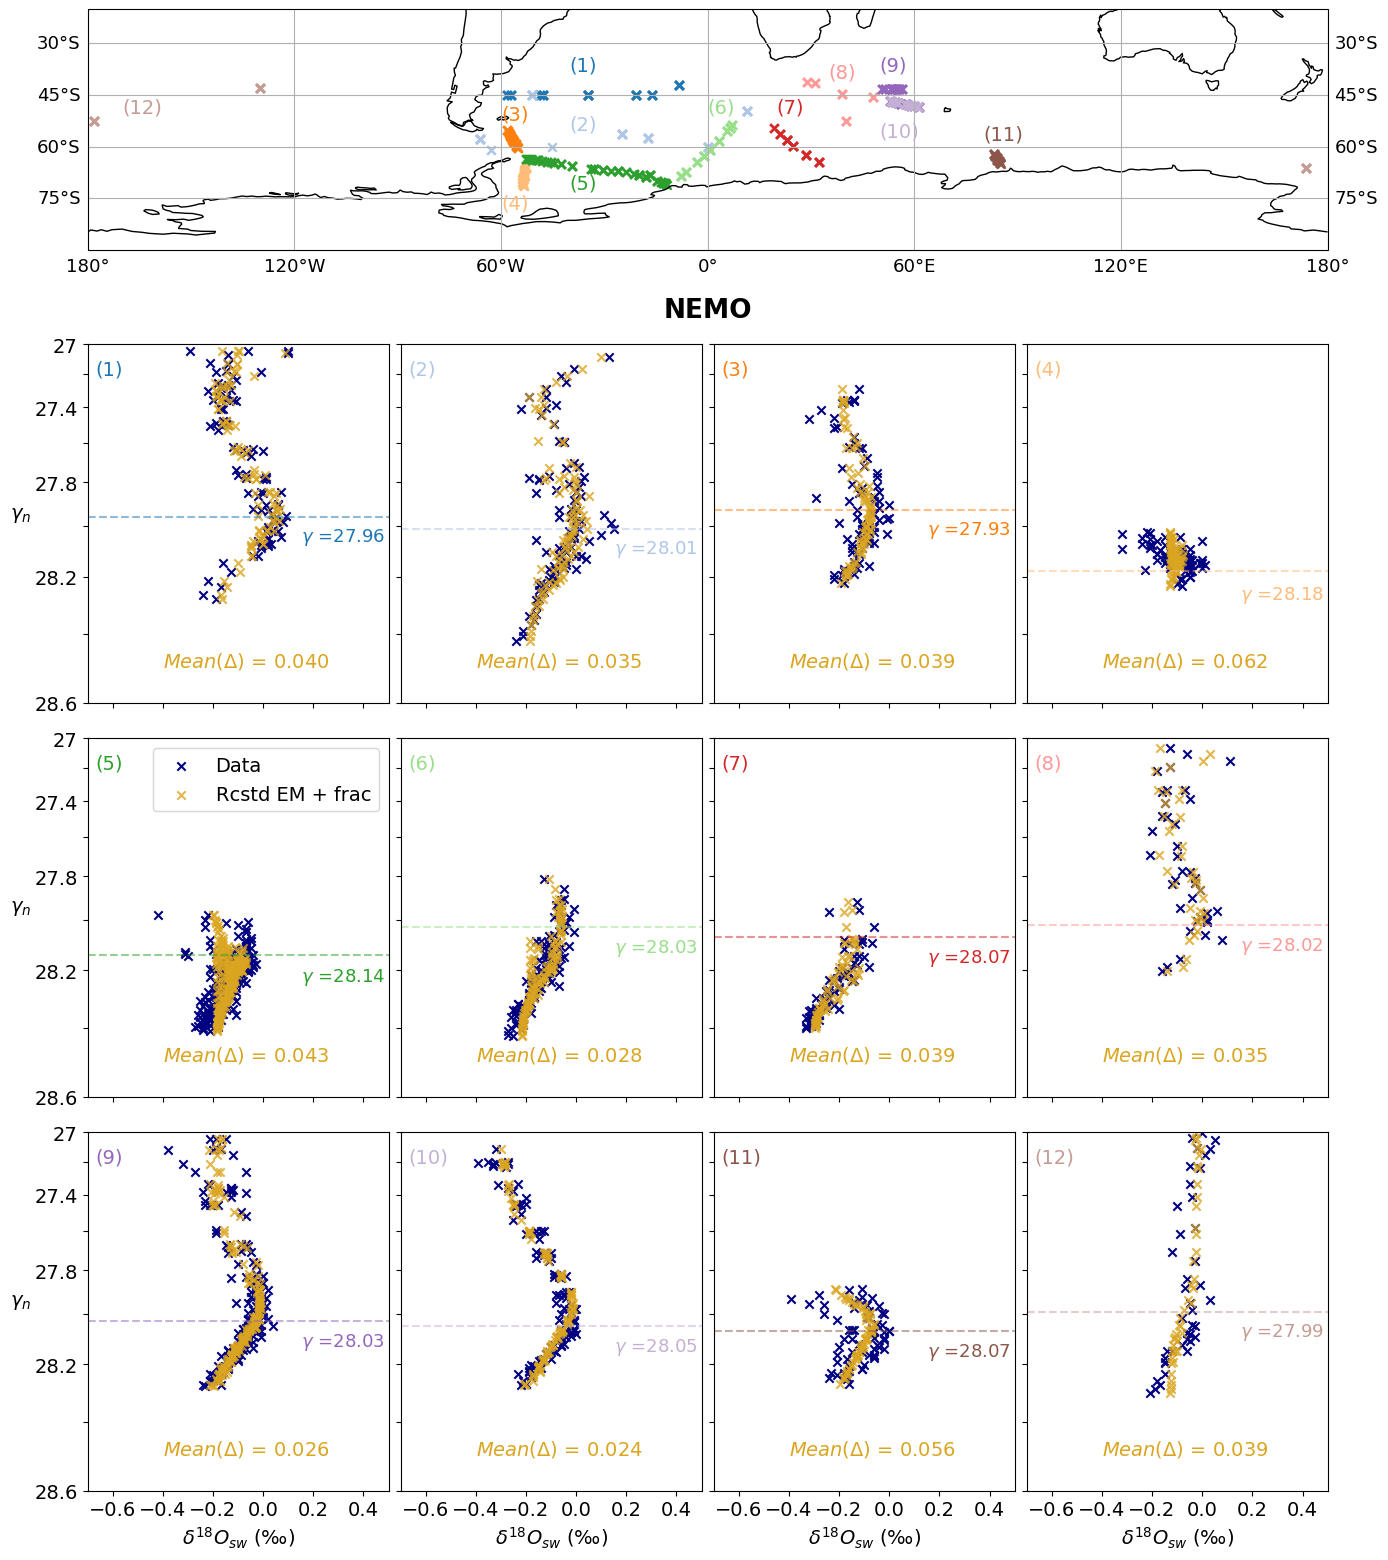

In [190]:
fig = plt.figure(figsize = (16, 20)); gs = fig.add_gridspec(4, 4, wspace = 0.04, hspace = 0.1); font = 14

ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m')
gl = ax.gridlines(draw_labels = {'bottom': 'x', 'right': 'y', 'left': 'y'}, ylocs = [-90 + 15 * i for i in range(5)])
gl.xlabel_style = {'size': font - 1}; gl.ylabel_style = {'size': font - 1}
ax.set_ylim(-90, -20); ax.set_xlim(-180, 180)
couleurs = plt.cm.tab20(range(12))
for i in range(12):
    ax.scatter(dfs2[i]['Longitude'], dfs2[i]['Latitude'], color = couleurs[i], marker = 'x')
    ax.text(uf.coords_dataset[i][0], uf.coords_dataset[i][1], '(' + str(i+1) + ')', fontsize = font, color = couleurs[i])

norm_S = uf.get_BoundNorm(34, 35, nbins = 20)
for i in range(12):
    i_row, i_col = i//4 + 1, i%4; xlabels, ylabels = uf.get_xylabels(3, 4, i)
    
    if (i_row == 1) & (i_col==2): ax.text(0.35, 26.8, model, fontsize = font + 5, fontweight = 'bold')
        
    ax = fig.add_subplot(gs[i_row, i_col])
    sc = ax.scatter(dfs2[i]['d18O'], dfs2[i]['Gamma'], marker = 'x', c = 'navy', alpha = 1, label = 'Data') #, norm = norm_S)
    ax.scatter(dfs2[i]['d18O_rcstd_opt'], dfs2[i]['Gamma'], marker = 'x', c = 'goldenrod', alpha = .8, label = 'Rcstd EM + frac')
# ax.scatter(dfs[i]['d18O_ocim_rcstd'], dfs[i]['Gamma'], marker = 'x', c = 'navy', alpha = 0.5)

    if i ==4: ax.legend(fontsize = font)
    ax.axhline(y = uf.l_neut_dens[i], ls = '--', color = couleurs[i], alpha = 0.5); ax.text(0.15, uf.l_neut_dens[i] + 0.1, '$\gamma$ =' + str(uf.l_neut_dens[i]), fontsize = font - 1, color = couleurs[i])
    
    if xlabels: ax.set_xlabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font)
    if ylabels: ax.set_ylabel('$\gamma_n$', fontsize = font, rotation = 0, labelpad = 10)

    ax.text(-0.4, 28.5, '$Mean(\Delta)$ = ' + format(np.nanmean(np.sqrt((dfs2[i]['d18O'] - dfs2[i]['d18O_rcstd_opt'])**2)), '.3f'), fontsize = font, color = 'goldenrod')
    ax.text(-0.67, 27.2, '(' + str(i + 1) + ')', fontsize = font, color = couleurs[i])
    
    ax.set_yscale('custom_scale')
    uf.plot_details_axis(ax, sc, cb = False, xlim = (-0.7, 0.5), ylim = (28.6, 27), nbins = 20, xticks = [-0.6 + 0.2*i for i in range(6)], yticks = [27 + 0.2*i for i in range(9)], font = font, xlabels = xlabels, ylabels = ylabels)
    ax.invert_yaxis()
    if ylabels: ax.set_yticklabels(['27', '', '27.4', '', '27.8', '', '28.2', '', '28.6'], fontsize = font)

plt.savefig(root_directory + fig_path + 'd18o_profiles_SO_map_' + model + '_rcs_dataset.png', bbox_inches = 'tight')

### Define a mean value for the EM based on the fractions

In [194]:
def index_to_exclude(suffix):
    index_to_exclude = []
    for j in range(len(dfs2)):
        if not (np.nanmax(dfs2[j]['dyeAA' + suffix]) >= 0.2) & (np.nanmax(dfs2[j]['dyeNA' + suffix]) >= 0.2) & (np.nanmax(dfs2[j]['dyeHS' + suffix]) >= 0.2):
            index_to_exclude.append(j)
    index_to_exclude.append(11)
    return index_to_exclude

In [196]:
def index_to_exclude_MS(suffix):
    index_to_exclude_MS = []
    for j in range(len(dfs2)):
        if not (np.nanmax(dfs2[j]['dyeMS' + suffix]) >= 0.2):
            index_to_exclude_MS.append(j)
    return index_to_exclude_MS

In [198]:
mean_EM = np.empty((3, 6)); i = 0
for suffix, EM in [('_TMI', d18o_EM_values_TMI), ('_ocim', d18o_EM_values_ocim), ('_nemo', d18o_EM_values_nemo)]:
    list_index = index_to_exclude(suffix)
    modify_d18o_EM_values = np.delete(EM, list_index, 1)
    mean_EM_values = np.nanmean(modify_d18o_EM_values, axis = 1)
    mean_EM_values[0] = 0.45; mean_EM_values[2] = -0.35

    mean_MS_value = np.nanmean(np.delete(EM, index_to_exclude_MS(suffix), 1), axis = 1)
    mean_EM_values[1] = mean_MS_value[1]
    mean_EM[i] = mean_EM_values
    i += 1

In [202]:
models_labels = ['TMI', 'OCIM', 'NEMO']; d18o_models = [d18o_EM_values_TMI, d18o_EM_values_ocim, d18o_EM_values_nemo]; suffixes = ['_TMI', '_ocim', '_nemo']

for k in range(3):
    for i in range(len(dfs2)):
        dfs2[i]['d18O_rcst_' + models_labels[k]] = np.nansum([dfs2[i][uf.dyes_TMI[j] + suffixes[k]] * d18o_models[k][j, i] for j in range(6)], axis = 0)
        dfs2[i]['d18O_rcst_mean_' + models_labels[k]] = np.nansum([dfs2[i][uf.dyes_TMI[j] + suffixes[k]] * mean_EM[k][j] for j in range(6)], axis = 0)

In [204]:
model_label = 'OCIM' # here change the label based on which ine we want to plot

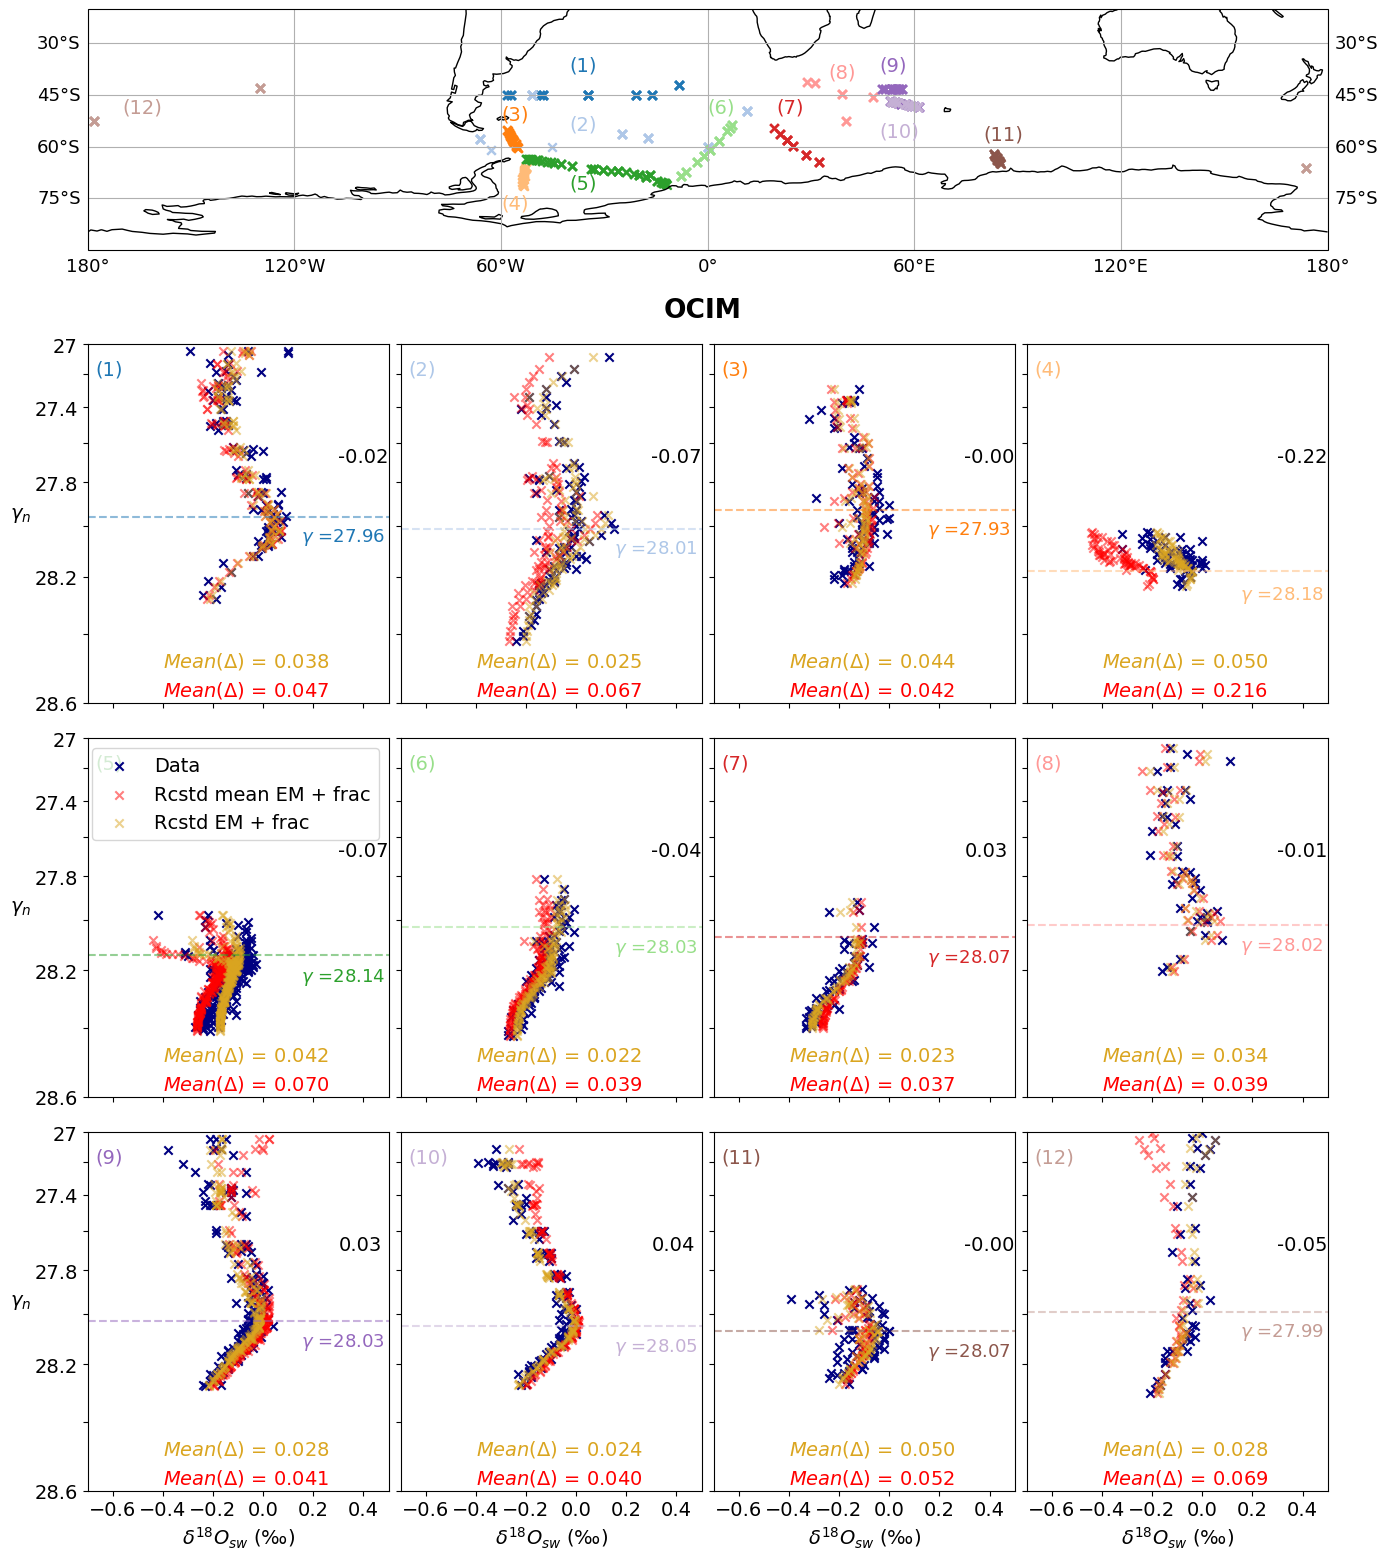

In [208]:
fig = plt.figure(figsize = (16, 20)); gs = fig.add_gridspec(4, 4, wspace = 0.04, hspace = 0.1); font = 14

ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m')
gl = ax.gridlines(draw_labels = {'bottom': 'x', 'right': 'y', 'left': 'y'}, ylocs = [-90 + 15 * i for i in range(5)])
gl.xlabel_style = {'size': font - 1}; gl.ylabel_style = {'size': font - 1}
ax.set_ylim(-90, -20); ax.set_xlim(-180, 180)
couleurs = plt.cm.tab20(range(12))
for i in range(12):
    ax.scatter(dfs2[i]['Longitude'], dfs2[i]['Latitude'], color = couleurs[i], marker = 'x')
    ax.text(uf.coords_dataset[i][0], uf.coords_dataset[i][1], '(' + str(i+1) + ')', fontsize = font, color = couleurs[i])

norm_S = uf.get_BoundNorm(34, 35, nbins = 20)
for i in range(12):
    i_row, i_col = i//4 + 1, i%4; xlabels, ylabels = uf.get_xylabels(3, 4, i)
    
    if (i_row == 1) & (i_col==2): ax.text(0.35, 26.8, model_label, fontsize = font + 5, fontweight = 'bold')
        
    ax = fig.add_subplot(gs[i_row, i_col])
    sc = ax.scatter(dfs2[i]['d18O'], dfs2[i]['Gamma'], marker = 'x', c = 'navy', alpha = 1, label = 'Data') #, norm = norm_S)
    ax.scatter(dfs2[i]['d18O_rcst_mean_' + model_label], dfs2[i]['Gamma'], marker = 'x', c = 'red', alpha = .5, label = 'Rcstd mean EM + frac')
    ax.scatter(dfs2[i]['d18O_rcst_' + model_label], dfs2[i]['Gamma'], marker = 'x', c = 'goldenrod', alpha = .5, label = 'Rcstd EM + frac')
# ax.scatter(dfs[i]['d18O_ocim_rcstd'], dfs[i]['Gamma'], marker = 'x', c = 'navy', alpha = 0.5)

    if i ==4: ax.legend(fontsize = font)
    ax.axhline(y = uf.l_neut_dens[i], ls = '--', color = couleurs[i], alpha = 0.5); ax.text(0.15, uf.l_neut_dens[i] + 0.1, '$\gamma$ =' + str(uf.l_neut_dens[i]), fontsize = font - 1, color = couleurs[i])
    
    if xlabels: ax.set_xlabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font)
    if ylabels: ax.set_ylabel('$\gamma_n$', fontsize = font, rotation = 0, labelpad = 10)

    ax.text(-0.4, 28.5, '$Mean(\Delta)$ = ' + format(np.nanmean(np.sqrt((dfs2[i]['d18O'] - dfs2[i]['d18O_rcst_' + model_label])**2)), '.3f'), fontsize = font, color = 'goldenrod')
    ax.text(-0.4, 28.58, '$Mean(\Delta)$ = ' + format(np.nanmean(np.sqrt((dfs2[i]['d18O'] - dfs2[i]['d18O_rcst_mean_' + model_label])**2)), '.3f'), fontsize = font, color = 'red')
    ax.text(-0.67, 27.2, '(' + str(i + 1) + ')', fontsize = font, color = couleurs[i])
    ax.text(0.3, 27.7, format(np.nanmean(dfs2[i]['d18O_rcst_mean_' + model_label] - dfs2[i]['d18O']), '.2f'), fontsize = font)
    
    ax.set_yscale('custom_scale')
    uf.plot_details_axis(ax, sc, cb = False, xlim = (-0.7, 0.5), ylim = (28.6, 27), nbins = 20, xticks = [-0.6 + 0.2*i for i in range(6)], yticks = [27 + 0.2*i for i in range(9)], font = font, xlabels = xlabels, ylabels = ylabels)
    ax.invert_yaxis()
    if ylabels: ax.set_yticklabels(['27', '', '27.4', '', '27.8', '', '28.2', '', '28.6'], fontsize = font)
# uf.add_cbar(fig, sc, y = 0.2, height = 0.35, fontsize = font, label = 'Salinity ($kg/m^3$)', ticks = [34 + i * 0.2 for i in range (6)])

plt.savefig(root_directory + fig_path + 'd18o_profiles_SO_map_' + model + '_rcs_dataset_&mean.png', bbox_inches = 'tight')

In [210]:
for k in range(3):
    aux2['d18O_rcst_mean_' + models_labels[k]] = np.nansum([aux2[uf.dyes_TMI[j] + suffixes[k]] * mean_EM[k][j] for j in range(6)], axis = 0)

In [212]:
from sklearn.metrics import root_mean_squared_error

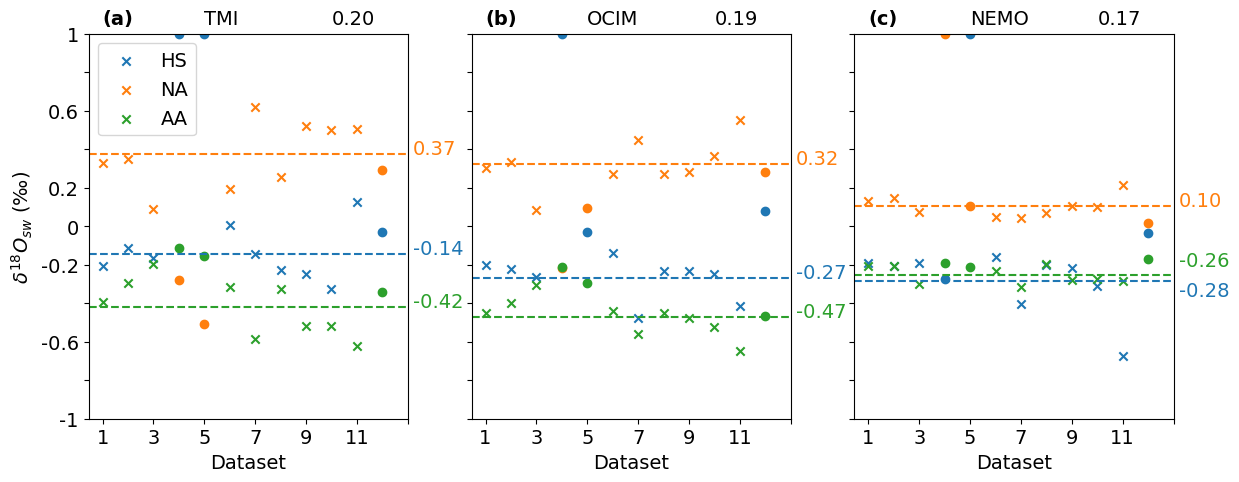

In [217]:
fig = plt.figure(figsize = (14, 5)); gs = fig.add_gridspec(1, 3, hspace = 0.12); font = 14
EM_values = [d18o_EM_values_TMI, d18o_EM_values_ocim, d18o_EM_values_nemo]
models = ['TMI', 'OCIM', 'NEMO']
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for j in range(3):
    ax = fig.add_subplot(gs[0, j]); ax.text(0, 1.05, uf.panels_letter_parenthesis[j], fontsize = font, fontweight = 'bold')
    if j == 0: ax.set_ylabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font)
    for i in [3, 4, 5]:
        idx_to_exclude = index_to_exclude(suffixes[j]); idx = [i for i in range(12)]
        ax.scatter(np.delete(idx, idx_to_exclude, 0), np.delete(EM_values[j][i, :], idx_to_exclude, 0), label = uf.dyes[i].replace('Dye', ''), marker = 'x', c = colors[i - 3])
        ax.scatter(idx_to_exclude, EM_values[j][i, idx_to_exclude], marker = 'o', c = colors[i - 3])
        # print(models[j] + ' ' + uf.dyes[i] + ' mean: ' + format(np.nanmean(EM_values[j][i, :]), '.2f'))
        
        ax.axhline(y = np.nanmean(np.delete(EM_values[j][i, :], idx_to_exclude, 0)), c = colors[i - 3], ls = '--')
        if (j == 2) & (i == 5): ax.text(12.2, np.nanmean(np.delete(EM_values[j][i, :], idx_to_exclude, 0)) + 0.05, format(np.nanmean(np.delete(EM_values[j][i, :], idx_to_exclude, 0)), '.2f'), c = colors[i - 3], fontsize = fontsize)
        elif (j == 2) & (i == 3): ax.text(12.2, np.nanmean(np.delete(EM_values[j][i, :], idx_to_exclude, 0)) - 0.08, format(np.nanmean(np.delete(EM_values[j][i, :], idx_to_exclude, 0)), '.2f'), c = colors[i - 3], fontsize = fontsize)
        else: ax.text(12.2, np.nanmean(np.delete(EM_values[j][i, :], idx_to_exclude, 0)), format(np.nanmean(np.delete(EM_values[j][i, :], idx_to_exclude, 0)), '.2f'), c = colors[i - 3], fontsize = fontsize)
        
                              
    ax.set_ylim(-1, 1); ax.text(4, 1.05, models[j], fontsize = font); ax.set_xticks([i*2 for i in range(7)]); ax.set_xticklabels([str(i*2 + 1) for i in range(6)] + [''], fontsize = fontsize); ax.set_xlabel('Dataset', fontsize = font)
    ax.set_yticks([-1 + 0.2 * i for i in range(11)]); ax.set_yticklabels([])
    if j ==0: ax.set_yticklabels([-1, '', -0.6, '', -0.2, 0, 0.2, '', 0.6, '', 1], fontsize = font); ax.legend(fontsize = font)
    ax.text(9, 1.05, format(root_mean_squared_error(aux2['d18O'].values, aux2['d18O_rcst_mean_' + models_labels[j]].values), '.2f'), fontsize = font)

plt.savefig(root_directory + fig_path + 'd18o_values_EM_12_datasets_3models.png', bbox_inches = 'tight')

### Save the reconstructed products

In [222]:
# takes a model and gives the EM values
def compute_EM_values(model):
    if model == 'TMI': suffix = '_TMI'; EM = d18o_EM_values_TMI
    elif model == 'OCIM': suffix = '_ocim'; EM = d18o_EM_values_ocim
    elif model == 'NEMO': suffix = '_nemo'; EM = d18o_EM_values_nemo
    
    index_to_exclude = []; index_to_exclude_MS = []
    for j in range(len(dfs2)):
        if not (np.nanmax(dfs2[j]['dyeAA' + suffix]) >= 0.2) & (np.nanmax(dfs2[j]['dyeNA' + suffix]) >= 0.2) & (np.nanmax(dfs2[j]['dyeHS' + suffix]) >= 0.2):
            index_to_exclude.append(j)
        if not (np.nanmax(dfs2[j]['dyeMS' + suffix]) >= 0.2):
            index_to_exclude_MS.append(j)
    index_to_exclude.append(11); print(index_to_exclude)

    mean_EM_values = np.nanmean(np.delete(EM, index_to_exclude, 1), axis = 1)
    mean_EM_values[0] = 0.45; mean_EM_values[2] = -0.35 # we modify the value for LL and NP patch
    
    mean_MS_value = np.nanmean(np.delete(EM, index_to_exclude_MS, 1), axis = 1)
    mean_EM_values[1] = mean_MS_value[1]

    return mean_EM_values 

In [226]:
mean_EM_values = compute_EM_values('NEMO')
nemo_dyes_regridded['d18o_recons'] = nemo_dyes_regridded[uf.dyes[0]] * mean_EM_values[0] + nemo_dyes_regridded[uf.dyes[1]] * mean_EM_values[1] + nemo_dyes_regridded[uf.dyes[2]] * mean_EM_values[2] + nemo_dyes_regridded[uf.dyes[3]] * mean_EM_values[3] + nemo_dyes_regridded[uf.dyes[4]] * mean_EM_values[4] + nemo_dyes_regridded[uf.dyes[5]] * mean_EM_values[5]
nemo_dyes_regridded.drop(labels = uf.dyes).to_netcdf(data_path + 'nemo_reconstructed_d18o.nc')

[3, 4, 11]


In [239]:
mean_EM_values = compute_EM_values('OCIM')
ocim_frac2['d18o_recons'] = ocim_frac2[uf.dyes_TMI[0] + '_steady'] * mean_EM_values[0] + ocim_frac2[uf.dyes_TMI[1] + '_steady'] * mean_EM_values[1] + ocim_frac2[uf.dyes_TMI[2] + '_steady'] * mean_EM_values[2] + ocim_frac2[uf.dyes_TMI[3] + '_steady'] * mean_EM_values[3] + ocim_frac2[uf.dyes_TMI[4] + '_steady'] * mean_EM_values[4] + ocim_frac2[uf.dyes_TMI[5] + '_steady'] * mean_EM_values[5]
ocim_frac2.drop(labels = ['dyeAA_steady', 'dyeHS_steady', 'dyeMS_steady', 'dyeLL_steady', 'dyeNP_steady', 'dyeNA_steady']).to_netcdf(data_path + 'ocim_reconstructed_d18o.nc')

[3, 4, 11]


In [241]:
mean_EM_values = compute_EM_values('TMI')
TMI_2deg['d18o_recons'] = TMI_2deg[uf.dyes_TMI[0]] * mean_EM_values[0] + TMI_2deg[uf.dyes_TMI[1]] * mean_EM_values[1] + TMI_2deg[uf.dyes_TMI[2]] * mean_EM_values[2] + TMI_2deg[uf.dyes_TMI[3]] * mean_EM_values[3] + TMI_2deg[uf.dyes_TMI[4]] * mean_EM_values[4]+ TMI_2deg[uf.dyes_TMI[5]] * mean_EM_values[5]
TMI_2deg.drop(labels = uf.dyes_TMI).to_netcdf(data_path + 'tmi_reconstructed_d18o.nc')

[3, 4, 11]
